## Create PBL Grid from SGP XSAPR

We define planetary boundary layer (PBL) grids as grids which cover a smaller domain typically 40 km x 40 km x 5 km in (x, y, z) with higher resolution of 250 m in all dimensions. In this notebook the grid origin will correspond to the SGP Central Facility.

In [2]:
%matplotlib inline

In [3]:
import tarfile
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.ticker import MultipleLocator
from matplotlib.colors import BoundaryNorm

from pyart.graph import cm
from pyart.io import read
from pyart.filters import GateFilter

from grid.core import Weight, Domain
from grid.interp import mapper

### Helper functions

In [4]:
def _plot_ppi(radar, field, sweep=0, max_range=40.0, cmap=None, norm=None, ticks=None, fig=None, ax=None):
    """
    """
    # Parse figure and axis
    if fig is None:
        fig = plt.gcf()
    if ax is None:
        ax = plt.gca()
    
    # Parse radar sweep coordinates
    _range = radar.range['data'] / 1000.0
    azimuth = np.radians(radar.get_azimuth(sweep))
    idx = np.abs(_range - max_range).argmin()
    
    # Compute (x, y) coordinates
    AZI, RNG = np.meshgrid(azimuth, _range[:idx+1], indexing='ij')
    X = RNG * np.sin(AZI)
    Y = RNG * np.cos(AZI)
    
    # Parse radar field data
    data = radar.get_field(sweep, field)[:,:idx+1]
    
    # Create quadmesh
    qm = ax.pcolormesh(
        X, Y, data, cmap=cmap, norm=norm, alpha=None, shading='flat', rasterized=True)
    
    # Create colour bar
    fig.colorbar(mappable=qm, ax=ax, orientation='vertical', ticks=ticks)
    
    # Set title
    title = '{} {:.1f} deg\n{}'.format(
        radar.metadata['instrument_name'], radar.fixed_angle['data'][sweep], field)
    ax.set_title(title)
    
    return

In [5]:
def _plot_cappi(grid, field, height=0, scale=1.0, cmap=None, norm=None, ticks=None, fig=None, ax=None):
    """
    """
    # Parse figure and axis
    if fig is None:
        fig = plt.gcf()
    if ax is None:
        ax = plt.gca()
    
    # Parse grid coordinates
    x_disp = grid.axes['x_disp']['data'] / 1000.0
    y_disp = grid.axes['y_disp']['data'] / 1000.0
    z_disp = grid.axes['z_disp']['data'] / 1000.0
    
    # Create quadmesh
    qm = ax.pcolormesh(
        x_disp, y_disp, scale * grid.fields[field]['data'][height], cmap=cmap, 
        norm=norm, alpha=None, shading='flat', rasterized=True)
    
    # Create colour bar
    fig.colorbar(mappable=qm, ax=ax, orientation='vertical', ticks=ticks)
    
    # Set title
    title = '{:.1f} km\n{}'.format(z_disp[height], field)
    ax.set_title(title)
    
    return

#### Format colour maps

In [25]:
# Define colour maps
cmap_refl = cm.NWSRef
cmap_vdop = cm.NWSVel
cmap_spw = cm.NWS_SPW
cmap_rhohv = cm.Carbone17
cmap_zdr = cm.RefDiff
cmap_phidp = cm.Wild25
cmap_kdp = cm.Theodore16
cmap_ncp = cm.Carbone17
cmap_class = cm.Carbone11
cmap_dist = cm.BlueBrown10
cmap_weight = cm.Carbone17
cmap_time = cm.BlueBrown10

# Normalize colour maps
norm_refl = BoundaryNorm(np.arange(-30, 55, 5), cmap_refl.N)
norm_vdop = BoundaryNorm(np.arange(-16, 18, 2), cmap_vdop.N)
norm_spw = BoundaryNorm(np.arange(0, 4.1, 0.1), cmap_spw.N)
norm_rhohv = BoundaryNorm(np.arange(0, 1.05, 0.05), cmap_rhohv.N)
norm_zdr = BoundaryNorm(np.arange(-6.0, 6.5, 0.5), cmap_zdr.N)
norm_phidp = BoundaryNorm(np.arange(0, 365, 5), cmap_phidp.N)
norm_kdp = BoundaryNorm(np.arange(-2, 8.2, 0.2), cmap_kdp.N)
norm_ncp = BoundaryNorm(np.arange(0, 1.05, 0.05), cmap_ncp.N)
norm_class = BoundaryNorm(np.arange(0, 7, 1), cmap_class.N)
norm_dist = BoundaryNorm(np.arange(0, 2.1, 0.1), cmap_dist.N)
norm_weight = BoundaryNorm(np.arange(0, 1.05, 0.05), cmap_weight.N)
norm_time = BoundaryNorm(np.arange(0, 250, 10), cmap_time.N)

# Define colour bar ticks
ticks_refl = np.arange(-30, 70, 20)
ticks_vdop = np.arange(-16, 20, 4)
ticks_spw = np.arange(0, 5, 1)
ticks_rhohv = np.arange(0, 1.2, 0.2)
ticks_zdr = np.arange(-6, 8, 2)
ticks_phidp = np.arange(0, 450, 90)
ticks_kdp = np.arange(-2, 10, 2)
ticks_ncp = np.arange(0, 1.2, 0.2)
ticks_class = np.arange(0, 7, 1)
ticks_dist = np.arange(0, 2.4, 0.4)
ticks_weight = np.arange(0, 1.2, 0.2)
ticks_time = np.arange(0, 280, 40)

#### Read radar data

In [8]:
filename = '/net/hydra/storage/common_data/MC3E/raw_data/xsapr_data/sgpxsaprppiI6.00.20110425.090004.tar'
tf = tarfile.TarFile(name=filename, mode='r', format=None)
for member in tf.getmembers():
    print member.name
member = tf.getmembers()[6]

XNW110425090004.RAWUBZ9
XNW110425090604.RAWUBZC
XNW110425091204.RAWUBZE
XNW110425091804.RAWUBZH
XNW110425092404.RAWUBZL
XNW110425093005.RAWUBZP
XNW110425093604.RAWUBZT
XNW110425094204.RAWUBZW
XNW110425094803.RAWUBZZ
XNW110425095404.RAWUC02


In [9]:
radar = read(tf.extractfile(member), exclude_fields=None)
tf.close()

In [10]:
# List available fields
for field in radar.fields.keys():
    print field

radar_echo_classification
corrected_reflectivity
differential_phase
cross_correlation_ratio
normalized_coherent_power
spectrum_width
total_power
reflectivity
differential_reflectivity
specific_differential_phase
velocity
corrected_differential_reflectivity


#### Plot PPI data

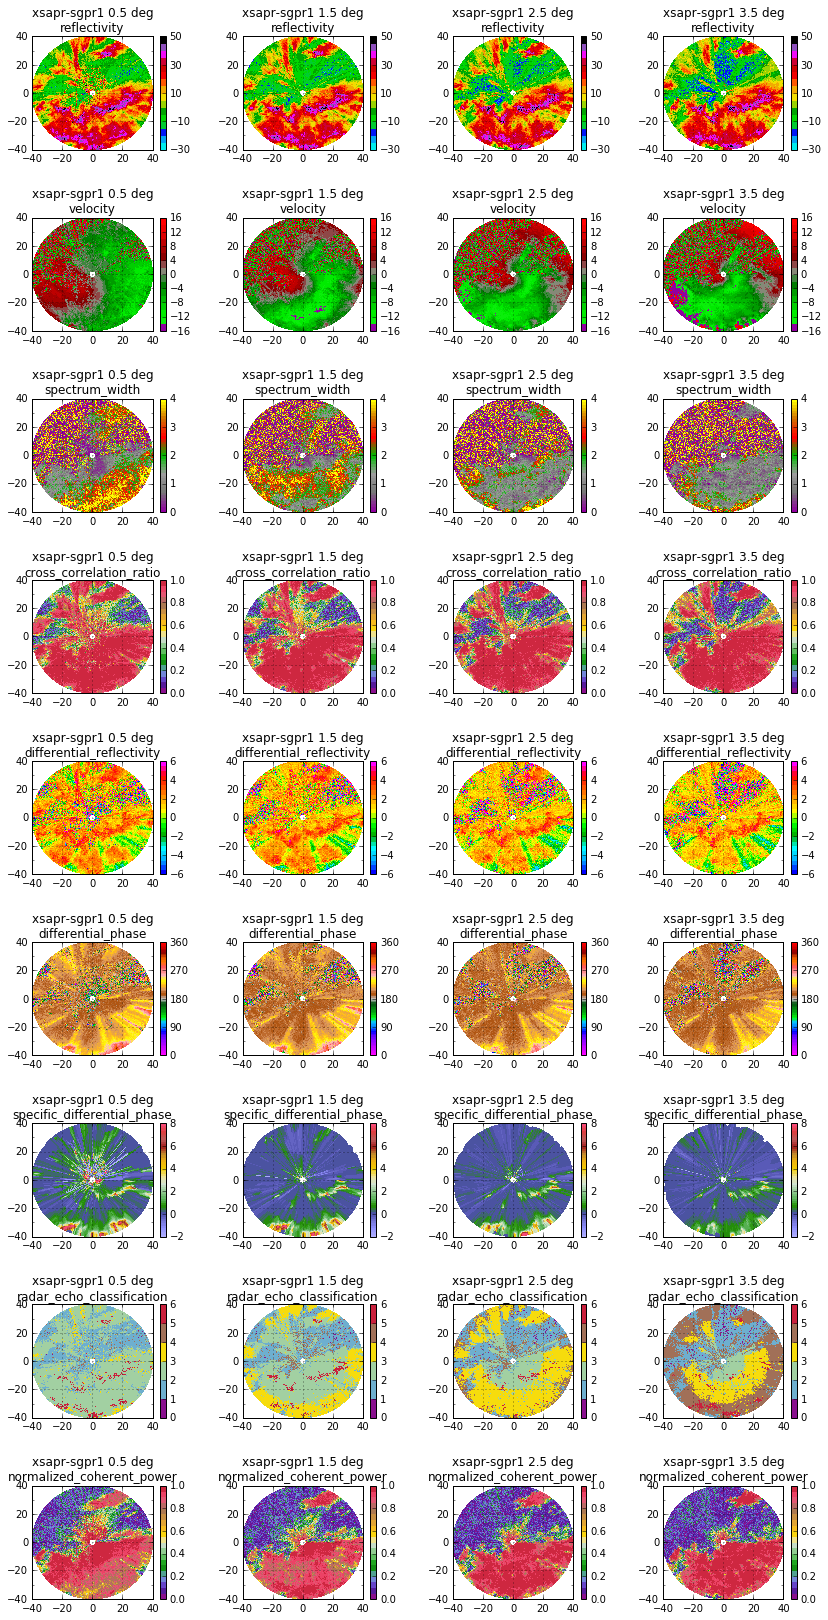

In [36]:
figs = {'figsize': (14, 28)}
subs = {'xlim': (-40, 40), 'ylim': (-40, 40)}
fig, axes = plt.subplots(nrows=9, ncols=4, subplot_kw=subs, **figs)
fig.subplots_adjust(wspace=0.4, hspace=0.6)

max_range = 40.0
sweeps = [0, 1, 2, 3]

for i, sweep in enumerate(sweeps):
    
    # (a) Reflectivity
    _plot_ppi(radar, 'reflectivity', sweep=sweep, max_range=max_range, cmap=cmap_refl, 
              norm=norm_refl, ticks=ticks_refl, fig=fig, ax=axes[0,i])
    
    # (b) Doppler velocity
    _plot_ppi(radar, 'velocity', sweep=sweep, max_range=max_range, cmap=cmap_vdop, 
              norm=norm_vdop, ticks=ticks_vdop, fig=fig, ax=axes[1,i])
    
    # (c) Spectrum width
    _plot_ppi(radar, 'spectrum_width', sweep=sweep, max_range=max_range, cmap=cmap_spw, 
              norm=norm_spw, ticks=ticks_spw, fig=fig, ax=axes[2,i])
    
    # (d) Copolar correlation coefficient
    _plot_ppi(radar, 'cross_correlation_ratio', sweep=sweep, max_range=max_range, 
              cmap=cmap_rhohv, norm=norm_rhohv, ticks=ticks_rhohv, fig=fig, ax=axes[3,i])
    
    # (e) Differential reflectivity
    _plot_ppi(radar, 'differential_reflectivity', sweep=sweep, max_range=max_range, 
              cmap=cmap_zdr, norm=norm_zdr, ticks=ticks_zdr, fig=fig, ax=axes[4,i])
    
    # (f) Differential phase
    _plot_ppi(radar, 'differential_phase', sweep=sweep, max_range=max_range, cmap=cmap_phidp, 
              norm=norm_phidp, ticks=ticks_phidp, fig=fig, ax=axes[5,i])
    
    # (g) Specific differential phase
    _plot_ppi(radar, 'specific_differential_phase', sweep=sweep, max_range=max_range, 
              cmap=cmap_kdp, norm=norm_kdp, ticks=ticks_kdp, fig=fig, ax=axes[6,i])
    
    # (h) Radar echo classification
    _plot_ppi(radar, 'radar_echo_classification', sweep=sweep, max_range=max_range, 
              cmap=cmap_class, norm=norm_class, ticks=ticks_class, fig=fig, ax=axes[7,i])
    
    # (i) Normalized coherent power
    _plot_ppi(radar, 'normalized_coherent_power', sweep=sweep, max_range=max_range, 
              cmap=cmap_ncp, norm=norm_ncp, ticks=ticks_ncp, fig=fig, ax=axes[8,i])
    
for ax in axes.flat:
    ax.xaxis.set_major_locator(MultipleLocator(20))
    ax.xaxis.set_minor_locator(MultipleLocator(20))
    ax.yaxis.set_major_locator(MultipleLocator(20))
    ax.yaxis.set_minor_locator(MultipleLocator(10))
    ax.grid(which='major')

### Create quick GateFilter

During mapping, the GateFilter is used to define the grid quality index.

In [27]:
gf = GateFilter(radar)
gf.exclude_below('radar_echo_classification', 2, op='or', inclusive=False)
gf.exclude_below('normalized_coherent_power', 0.3, op='or', inclusive=False)

### Grid radar data

In [28]:
# Define grid coordinates
coords = [
    np.arange(0.0, 5250.0, 250.0),
    np.arange(-20000.0, 20250.0, 250.0),
    np.arange(-20000.0, 20250.0, 250.0)
    ]

# Define grid origin
origin = (36.605, -97.485, None)

# Define fields to grid
fields = [
    'reflectivity', 
    'velocity',
    'spectrum_width',
    'cross_correlation_ratio',
    'differential_reflectivity',
    'differential_phase',
    'specific_differential_phase',
    'normalized_coherent_power',
    'radar_echo_classification',
    ]

In [29]:
# Create grid domain
domain = Domain(coords, origin, proj='lcca', ellps='WGS84', datum='WGS84', dem=None)

In [30]:
# List available domain attributes
for attr in domain.__dict__.keys():
    print attr

lon_0
dem
alt_0
radar_offset
nx
ny
nz
proj
y
x
z
geod
lat_0


#### Nearest neighbour

In [31]:
grid = mapper.grid_radar_nearest_neighbour(
    radar, domain, fields=fields, gatefilter=gf, toa=17000.0, max_range=None, 
    leafsize=10, legacy=True, debug=True, verbose=True)

Radar x in grid: -5.60 km
Radar y in grid: 18.04 km
Radar z in grid: 0.00 km
Number of radar gates before pruning: 7048800
Number of radar gates below TOA: 6536632
Creating k-d tree instance for radar gate locations
tree.m = 3
tree.n = 6536632
Number of x grid points: 161
Number of y grid points: 161
Number of z grid points: 21
Grid 1-D array shape: (544341,)
Querying k-d tree for the k-nearest analysis grid points
Distance array shape: (544341,)
Minimum gate-grid distance: 1.06 m
Maximum gate-grid distance: 6142.37 m
Index array shape: (544341,)
Minimum index: 2442
Maximum index: 6534514
Number of analysis points too far from radar: 15712
Mapping radar field: reflectivity
Mapping radar field: velocity
Mapping radar field: spectrum_width
Mapping radar field: cross_correlation_ratio
Mapping radar field: differential_reflectivity
Mapping radar field: differential_phase
Mapping radar field: specific_differential_phase
Mapping radar field: normalized_coherent_power
Mapping radar field: rad

/aos/home/kirk/projects/pyart/pyart/core/grid.py:182: DeprecationWarning: from_legacy_parameters is deprecated and will be removed in a future version of Py-ART
  "future version of Py-ART", DeprecationWarning)


In [32]:
# Print available mapped fields
for field in grid.fields.keys():
    print field

grid_quality_index
radar_echo_classification
differential_phase
cross_correlation_ratio
normalized_coherent_power
spectrum_width
reflectivity
nearest_neighbor_distance
differential_reflectivity
specific_differential_phase
velocity
nearest_neighbor_time


#### Plot nearest neighbour results

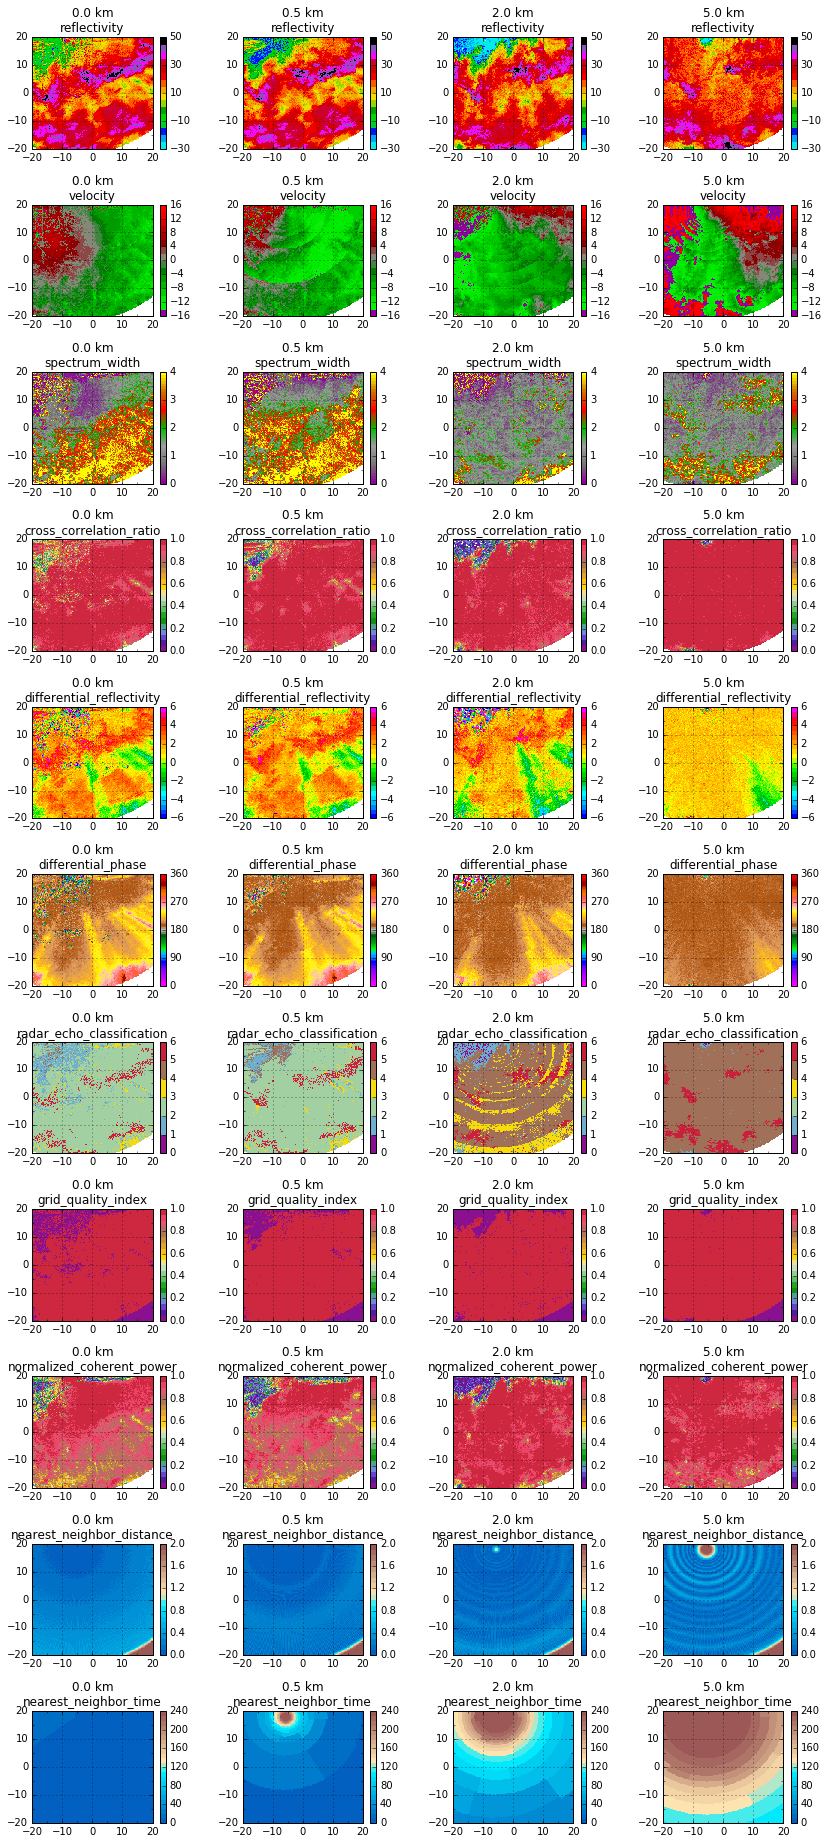

In [34]:
figs = {'figsize': (14, 32)}
subs = {'xlim': (-20, 20), 'ylim': (-20, 20)}
fig, axes = plt.subplots(nrows=11, ncols=4, subplot_kw=subs, **figs)
fig.subplots_adjust(wspace=0.4, hspace=0.5)

heights = [0, 2, 8, 20]

for i, height in enumerate(heights):
    
    # (a) Reflectivity
    _plot_cappi(grid, 'reflectivity', height=height, cmap=cmap_refl, 
                norm=norm_refl, ticks=ticks_refl, fig=fig, ax=axes[0,i])
    
    # (b) Doppler velocity
    _plot_cappi(grid, 'velocity', height=height, cmap=cmap_vdop, 
                norm=norm_vdop, ticks=ticks_vdop, fig=fig, ax=axes[1,i])
    
    # (c) Spectrum width
    _plot_cappi(grid, 'spectrum_width', height=height, cmap=cmap_spw,
                norm=norm_spw, ticks=ticks_spw, fig=fig, ax=axes[2,i])
    
    # (d) Copolar correlation coefficient
    _plot_cappi(grid, 'cross_correlation_ratio', height=height, cmap=cmap_rhohv, 
                norm=norm_rhohv, ticks=ticks_rhohv, fig=fig, ax=axes[3,i])
    
    # (e) Differential reflectivity
    _plot_cappi(grid, 'differential_reflectivity', height=height, cmap=cmap_zdr, 
                norm=norm_zdr, ticks=ticks_zdr, fig=fig, ax=axes[4,i])
    
    # (f) Differential phase
    _plot_cappi(grid, 'differential_phase', height=height, cmap=cmap_phidp,
                norm=norm_phidp, ticks=ticks_phidp, fig=fig, ax=axes[5,i])
    
    # (g) Radar echo classification
    _plot_cappi(grid, 'radar_echo_classification', height=height, cmap=cmap_class,
                norm=norm_class, ticks=ticks_class, fig=fig, ax=axes[6,i])
    
    # (h) Grid quality index
    _plot_cappi(grid, 'grid_quality_index', height=height, cmap=cmap_ncp,
                norm=norm_ncp, ticks=ticks_ncp, fig=fig, ax=axes[7,i])
    
    # (i) Normalized coherent power
    _plot_cappi(grid, 'normalized_coherent_power', height=height, cmap=cmap_ncp,
                norm=norm_ncp, ticks=ticks_ncp, fig=fig, ax=axes[8,i])
    
    # (j) Nearest neighbour distance
    _plot_cappi(grid, 'nearest_neighbor_distance', height=height, scale=1.0e-3, 
                cmap=cmap_dist, norm=norm_dist, ticks=ticks_dist, fig=fig, 
                ax=axes[9,i])
    
    # (k) Nearest neighbour time
    _plot_cappi(grid, 'nearest_neighbor_time', height=height, cmap=cmap_time, 
                norm=norm_time, ticks=ticks_time, fig=fig, ax=axes[10,i])

# Format axes
for ax in axes.flat:
    ax.xaxis.set_major_locator(MultipleLocator(10))
    ax.xaxis.set_minor_locator(MultipleLocator(5))
    ax.yaxis.set_major_locator(MultipleLocator(10))
    ax.yaxis.set_minor_locator(MultipleLocator(5))
    ax.grid(which='major')

#### Isotropic Barnes

In [37]:
# Define analysis weight
weight = Weight(
    func=None, cutoff_radius=np.inf, k=5, kappa_star=0.5, data_spacing=500.0)
weight.compute_distance_weight_vanishes(atol=0.001, verbose=True)

Distance weight vanishes: 1900.00 m


In [38]:
for attr in weight.__dict__.keys():
    print attr

x_g
x_ref
kappa
func
inds
z_ref
k
y_ref
radar_tree
data_spacing
leafsize
pool
wq
z_g
y_g
cutoff_radius
proc
dists
kappa_star
distance_weight_vanishes


In [39]:
grid = mapper.grid_radar(
    radar, domain, weight=weight, fields=fields, gatefilter=gf, toa=17000.0, 
    max_range=None, legacy=True, debug=True, verbose=True)

Radar x in grid: -5.60 km
Radar y in grid: 18.04 km
Radar z in grid: 0.00 km
Number of radar gates before pruning: 7048800
Number of radar gates below TOA: 6536632
Number of x grid points: 161
Number of y grid points: 161
Number of z grid points: 21
Grid 1-D array shape: (544341,)
No radar kd-tree exists
Creating k-d tree instance for radar gate locations
tree.m = 3
tree.n = 6536632
Querying k-d tree for the k-nearest analysis grid points
Elapsed time for query: 2.18 sec
Distance array shape: (544341, 5)
Minimum gate-grid distance: 1.06 m
Maximum gate-grid distance: 6192.24 m
Index array shape: (544341, 5)
Minimum index: 1641
Maximum index: 6534958
Computing distance-dependent weights
Number of invalid indices: 0
Number of analysis points too far from radar: 15712
Mapping radar field: reflectivity
Mapping radar field: velocity
Mapping radar field: spectrum_width
Mapping radar field: cross_correlation_ratio
Mapping radar field: differential_reflectivity
Mapping radar field: differential

/aos/home/kirk/projects/pyart/pyart/core/grid.py:182: DeprecationWarning: from_legacy_parameters is deprecated and will be removed in a future version of Py-ART
  "future version of Py-ART", DeprecationWarning)


In [40]:
# Print available gridded fields
for field in grid.fields.keys():
    print field

grid_quality_index
radar_echo_classification
differential_phase
cross_correlation_ratio
normalized_coherent_power
spectrum_width
reflectivity
nearest_neighbor_distance
differential_reflectivity
specific_differential_phase
nearest_neighbor_weight
velocity
nearest_neighbor_time


#### Plot Barnes results

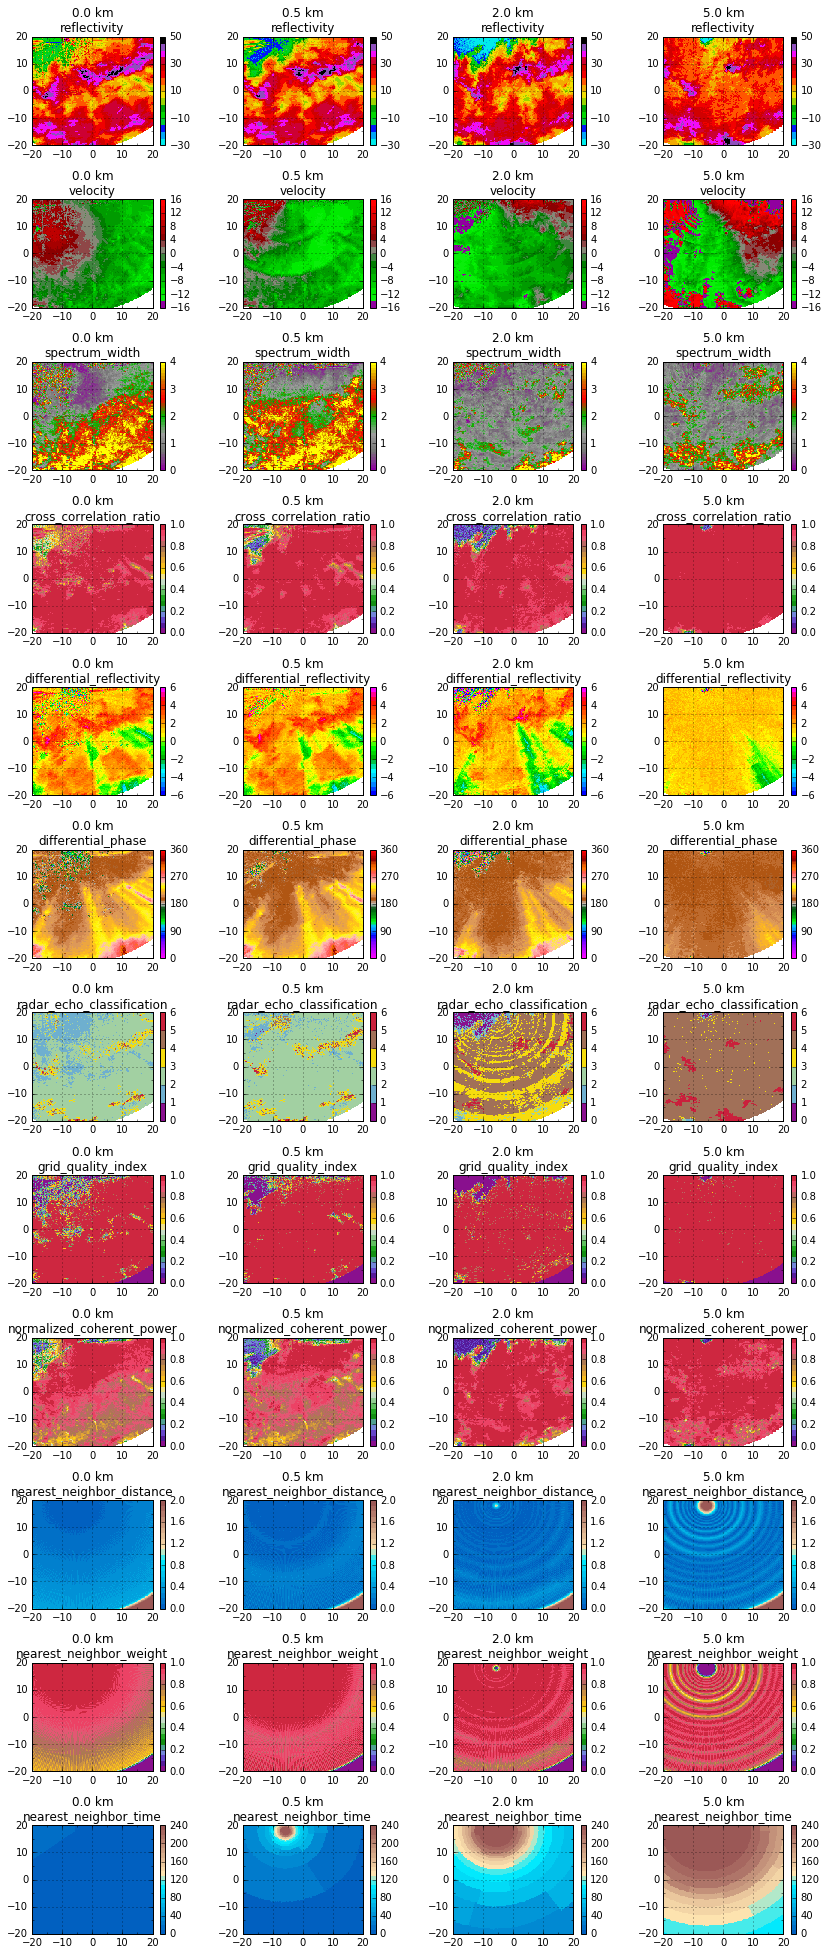

In [41]:
figs = {'figsize': (14, 34)}
subs = {'xlim': (-20, 20), 'ylim': (-20, 20)}
fig, axes = plt.subplots(nrows=12, ncols=4, subplot_kw=subs, **figs)
fig.subplots_adjust(wspace=0.4, hspace=0.5)

heights = [0, 2, 8, 20]

for i, height in enumerate(heights):
    
    # (a) Reflectivity
    _plot_cappi(grid, 'reflectivity', height=height, cmap=cmap_refl, 
                norm=norm_refl, ticks=ticks_refl, fig=fig, ax=axes[0,i])
    
    # (b) Doppler velocity
    _plot_cappi(grid, 'velocity', height=height, cmap=cmap_vdop, 
                norm=norm_vdop, ticks=ticks_vdop, fig=fig, ax=axes[1,i])
    
    # (c) Spectrum width
    _plot_cappi(grid, 'spectrum_width', height=height, cmap=cmap_spw,
                norm=norm_spw, ticks=ticks_spw, fig=fig, ax=axes[2,i])
    
    # (d) Copolar correlation coefficient
    _plot_cappi(grid, 'cross_correlation_ratio', height=height, cmap=cmap_rhohv, 
                norm=norm_rhohv, ticks=ticks_rhohv, fig=fig, ax=axes[3,i])
    
    # (e) Differential reflectivity
    _plot_cappi(grid, 'differential_reflectivity', height=height, cmap=cmap_zdr, 
                norm=norm_zdr, ticks=ticks_zdr, fig=fig, ax=axes[4,i])
    
    # (f) Differential phase
    _plot_cappi(grid, 'differential_phase', height=height, cmap=cmap_phidp,
                norm=norm_phidp, ticks=ticks_phidp, fig=fig, ax=axes[5,i])
    
    # (g) Radar echo classification
    _plot_cappi(grid, 'radar_echo_classification', height=height, cmap=cmap_class,
                norm=norm_class, ticks=ticks_class, fig=fig, ax=axes[6,i])
    
    # (h) Grid quality index
    _plot_cappi(grid, 'grid_quality_index', height=height, cmap=cmap_ncp,
                norm=norm_ncp, ticks=ticks_ncp, fig=fig, ax=axes[7,i])
    
    # (i) Normalized coherent power
    _plot_cappi(grid, 'normalized_coherent_power', height=height, cmap=cmap_ncp,
                norm=norm_ncp, ticks=ticks_ncp, fig=fig, ax=axes[8,i])
    
    # (j) Nearest neighbour distance
    _plot_cappi(grid, 'nearest_neighbor_distance', height=height, scale=1.0e-3, 
                cmap=cmap_dist, norm=norm_dist, ticks=ticks_dist, fig=fig, 
                ax=axes[9,i])
    
    # (k) Nearest neighbour weight
    _plot_cappi(grid, 'nearest_neighbor_weight', height=height, cmap=cmap_weight, 
                norm=norm_weight, ticks=ticks_weight, fig=fig, ax=axes[10,i])
    
    # (l) Nearest neighbour time
    _plot_cappi(grid, 'nearest_neighbor_time', height=height, cmap=cmap_time, 
                norm=norm_time, ticks=ticks_time, fig=fig, ax=axes[11,i])

# Format axes
for ax in axes.flat:
    ax.xaxis.set_major_locator(MultipleLocator(10))
    ax.xaxis.set_minor_locator(MultipleLocator(5))
    ax.yaxis.set_major_locator(MultipleLocator(10))
    ax.yaxis.set_minor_locator(MultipleLocator(5))
    ax.grid(which='major')